## CDS 301

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
def read_csv(file_path):
    return pd.read_csv(open(file_path))

gpu_specs_path = "./data/GPU_Specs.csv"
gpu_scores_path = "./data/GPU_Scores.csv"
gpu_benchmark_path = "./data/GPU_Benchmarks.csv"

df_specs = read_csv(gpu_specs_path)
df_scores = read_csv(gpu_scores_path)
df_benchmarks = read_csv(gpu_benchmark_path)

## Data Previewing

In [3]:
### SIZE OF DATAFRAMES ###
def preview_size(idx, dataframe):
    print(idx,"-",dataframe.shape)

preview_size("Specs", df_specs)
preview_size("Scores", df_scores)
preview_size("Benchmarks", df_benchmarks)

Specs - (3056, 16)
Scores - (1213, 6)
Benchmarks - (2317, 9)


In [4]:
### DATA DICTIONARY ###
def data_dictionary(dataframe):
    new_df = pd.DataFrame({"Column": [], "Type": [], "Missing Data": [], "Percentage Missing": []})
    for column in dataframe.columns:
        new_df.loc[len(new_df)] = {"Column": str(column), "Type": dataframe[column].dtype, "Missing Data": dataframe[column].isna().sum(), "Percentage Missing": round((dataframe[column].isna().sum()/len(dataframe[column])*100), 2)}
    return new_df


In [5]:
data_dictionary(df_specs)

,Column,Type,Missing Data,Percentage Missing
0,manufacturer,object,0,0.00
1,productName,object,0,0.00
2,releaseYear,float64,44,1.44
3,memSize,float64,441,14.43
4,memBusWidth,float64,2868,93.85
5,gpuClock,int64,0,0.00
6,memClock,float64,441,14.43
7,unifiedShader,float64,824,26.96
8,tmu,int64,0,0.00
9,rop,int64,0,0.00


In [6]:
data_dictionary(df_scores)

,Column,Type,Missing Data,Percentage Missing
0,Manufacturer,object,0,0.00
1,Device,object,0,0.00
2,CUDA,float64,947,78.07
3,Metal,float64,972,80.13
4,OpenCL,float64,237,19.54
5,Vulkan,float64,584,48.15


In [7]:
data_dictionary(df_benchmarks)

,Column,Type,Missing Data,Percentage Missing
0,gpuName,object,0,0.00
1,G3Dmark,int64,0,0.00
2,G2Dmark,int64,0,0.00
3,price,float64,1764,76.13
4,gpuValue,float64,1764,76.13
5,TDP,float64,1625,70.13
6,powerPerformance,float64,1625,70.13
7,testDate,int64,0,0.00
8,category,object,0,0.00


In [8]:
df_specs.head()

,manufacturer,productName,releaseYear,memSize,memBusWidth,gpuClock,memClock,unifiedShader,tmu,rop,pixelShader,vertexShader,igp,bus,memType,gpuChip
0,NVIDIA,GeForce RTX 5090,2025.0,28.0,448.0,900,1200.0,8192.0,256,128,NaN,NaN,No,PCIe 4.0 x16,HBM2e,Arctic Sound
1,NVIDIA,GeForce RTX 5080,2025.0,16.0,256.0,900,1215.0,6912.0,432,192,NaN,NaN,No,PCIe 4.0 x16,HBM2e,GA100
2,NVIDIA,GeForce RTX 5070,2025.0,12.0,192.0,1825,2000.0,5120.0,320,128,NaN,NaN,No,PCIe 4.0 x16,GDDR6,Navi 21
3,NVIDIA,GeForce RTX 5060 Mobile,2025.0,8.0,128.0,2235,2500.0,4608.0,144,48,NaN,NaN,No,PCIe 5.0 x16,GDDR7,GB206
4,NVIDIA,GeForce RTX 5060,2025.0,8.0,128.0,1825,2250.0,4608.0,288,192,NaN,NaN,No,PCIe 4.0 x16,GDDR6,Navi 31


## Data Cleaning

In [9]:
### Cleaning df_specs ###
df_specs_final = df_specs.drop(columns=["memBusWidth", "pixelShader", "vertexShader"])
df_specs_final = df_specs_final.rename(columns={"productName": "product_name", "releaseYear": "release_year",
                                                "memSize": "memory_size", "gpuClock": "gpu_clock", "memClock": "memory_clock",
                                                "unifiedShader": "unified_shader", "tmu": "texture_mapping_units", "rop": "render_output_units",
                                                "igp": "integrated_graphics_processor", "memType": "memory_type", "gpuChip": "gpu_chip"})
df_specs_final["integrated_graphics_processor"] = df_specs_final["integrated_graphics_processor"].map({"Yes": 1, "No": 0}).astype(bool)
df_specs_final = df_specs_final.dropna(subset=["release_year"])
df_specs_final['memory_size'] = df_specs_final.groupby('release_year')['memory_size'].transform(lambda x: x.fillna(x.median()))
df_specs_final['memory_clock'] = df_specs_final.groupby('release_year')['memory_clock'].transform(lambda x: x.fillna(x.median()))
df_specs_final['unified_shader'] = df_specs_final.groupby('release_year')['unified_shader'].transform(lambda x: x.fillna(0))
df_specs_final["memory_type"] = df_specs_final["memory_type"].replace("^\s+", "", regex=True).replace("\s+$", "", regex=True)
df_specs_final["memory_type"] = df_specs_final["memory_type"].fillna("None")
data_dictionary(df_specs_final)

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1961/1724038724.py:12: SyntaxWarning: invalid escape sequence '\s'
  df_specs_final["memory_type"] = df_specs_final["memory_type"].replace("^\s+", "", regex=True).replace("\s+$", "", regex=True)
/tmp/ipykernel_1961/1724038724.py:12: SyntaxWarning: invalid escape sequence '\s'
  df_specs_final["memory_type"] = df_specs_final["memory_type"].replace("^\s+", "", regex=True).replace("\s+$", "", regex=True)


,Column,Type,Missing Data,Percentage Missing
0,manufacturer,object,0,0.0
1,product_name,object,0,0.0
2,release_year,float64,0,0.0
3,memory_size,float64,0,0.0
4,gpu_clock,int64,0,0.0
5,memory_clock,float64,0,0.0
6,unified_shader,float64,0,0.0
7,texture_mapping_units,int64,0,0.0
8,render_output_units,int64,0,0.0
9,integrated_graphics_processor,bool,0,0.0


In [10]:
df_specs_final.head()

,manufacturer,product_name,release_year,memory_size,gpu_clock,memory_clock,unified_shader,texture_mapping_units,render_output_units,integrated_graphics_processor,bus,memory_type,gpu_chip
0,NVIDIA,GeForce RTX 5090,2025.0,28.0,900,1200.0,8192.0,256,128,False,PCIe 4.0 x16,HBM2e,Arctic Sound
1,NVIDIA,GeForce RTX 5080,2025.0,16.0,900,1215.0,6912.0,432,192,False,PCIe 4.0 x16,HBM2e,GA100
2,NVIDIA,GeForce RTX 5070,2025.0,12.0,1825,2000.0,5120.0,320,128,False,PCIe 4.0 x16,GDDR6,Navi 21
3,NVIDIA,GeForce RTX 5060 Mobile,2025.0,8.0,2235,2500.0,4608.0,144,48,False,PCIe 5.0 x16,GDDR7,GB206
4,NVIDIA,GeForce RTX 5060,2025.0,8.0,1825,2250.0,4608.0,288,192,False,PCIe 4.0 x16,GDDR6,Navi 31


In [11]:
df_specs_final[df_specs_final["memory_type"] == "GDDR6"][["manufacturer", "release_year", "memory_clock", "memory_type"]]

,manufacturer,release_year,memory_clock,memory_type
2,NVIDIA,2025.0,2000.0,GDDR6
4,NVIDIA,2025.0,2250.0,GDDR6
5,NVIDIA,2025.0,2000.0,GDDR6
11,NVIDIA,2024.0,2250.0,GDDR6
16,NVIDIA,2024.0,1750.0,GDDR6
...,...,...,...,...
2411,Sony,2005.0,1937.0,GDDR6
2508,Sony,2004.0,1750.0,GDDR6
2522,ATI,2004.0,1250.0,GDDR6
2523,ATI,2004.0,1250.0,GDDR6


In [12]:
df_specs_final["memory_type"].unique()

array(['HBM2e', 'GDDR6', 'GDDR7', 'HBM3e', 'HBM3', 'GDDR6X', 'DDR',
       'HBM2', 'GDDR3', 'DDR2', 'HBM', 'GDDR5X', 'GDDR5', 'LPDDR5',
       'DDR3', 'None', 'SDR', 'DDR4', 'GDDR4', 'eDRAM', 'LPDDR4X', 'SGR',
       'EDO', 'DRAM', 'GDDR2', 'FPM', 'VRAM', 'SGRAM', 'CDRAM'],
      dtype=object)

In [13]:
### Cleaning df_scores ###
df_scores_final = df_scores.copy()
df_scores_final["CUDA"] = df_scores_final["CUDA"].fillna(0)
df_scores_final["Metal"] = df_scores_final["Metal"].fillna(0)
df_scores_final["OpenCL"] = df_scores_final["OpenCL"].fillna(0)
df_scores_final["Vulkan"] = df_scores_final["Vulkan"].fillna(0)
df_scores_final = df_scores_final.rename(columns={"Manufacturer": "manufacturer", "Device": "product_name"})
data_dictionary(df_scores_final)

,Column,Type,Missing Data,Percentage Missing
0,manufacturer,object,0,0.0
1,product_name,object,0,0.0
2,CUDA,float64,0,0.0
3,Metal,float64,0,0.0
4,OpenCL,float64,0,0.0
5,Vulkan,float64,0,0.0


In [14]:
### Cleaning df_benchmarks ###
df_benchmarks_final = df_benchmarks.copy()
df_benchmarks_final[["manufacturer", "product_name"]] = df_benchmarks_final["gpuName"].str.split(" ", n=1, expand=True)
df_benchmarks_final = df_benchmarks_final.drop(columns=["gpuName"])
df_benchmarks_final = df_benchmarks_final.rename(columns={"gpuValue": "gpu_value", "powerPerformance": "power_performance", "testDate": "test_date", "TDP": "thermal_design_power"})
df_benchmarks_final = df_benchmarks_final.dropna(subset=["product_name"])
data_dictionary(df_benchmarks_final)

,Column,Type,Missing Data,Percentage Missing
0,G3Dmark,int64,0,0.00
1,G2Dmark,int64,0,0.00
2,price,float64,1741,76.13
3,gpu_value,float64,1741,76.13
4,thermal_design_power,float64,1595,69.74
5,power_performance,float64,1595,69.74
6,test_date,int64,0,0.00
7,category,object,0,0.00
8,manufacturer,object,0,0.00
9,product_name,object,0,0.00


In [15]:
df_benchmarks_final.head()

,G3Dmark,G2Dmark,price,gpu_value,thermal_design_power,power_performance,test_date,category,manufacturer,product_name
0,29094,1117,2099.99,13.85,450.0,64.65,2022,Unknown,GeForce,RTX 3090 Ti
1,26887,1031,1199.99,22.41,350.0,76.82,2021,Desktop,GeForce,RTX 3080 Ti
2,26395,999,1749.99,15.08,350.0,75.41,2020,Desktop,GeForce,RTX 3090
3,25458,1102,1120.31,22.72,300.0,84.86,2020,Desktop,Radeon,RX 6900 XT
4,24853,1003,999.00,24.88,320.0,77.66,2020,Desktop,GeForce,RTX 3080


In [16]:
df_benchmarks_final["manufacturer"].unique()

array(['GeForce', 'Radeon', 'RTX', 'TITAN', 'Quadro', 'NVIDIA', 'Tesla',
       'Miracast', 'RadeonT', 'T1200', 'T1000', 'FirePro', 'Ryzen',
       'T600', 'GRID', 'T550', 'EIZO', 'Barco', 'Citrix', 'T400', 'Intel',
       'Custom', 'MONSTER', 'FireStream', 'Matrox', 'Embedded',
       'Qualcomm', 'Seria', 'Firepro', 'TENSOR', 'NVS', 'Mobility',
       'OPAL', 'zxcvIntel', 'Radeon.', '7900', 'FireGL', '3DP',
       'IncrediblE', 'Asus', 'TRINITY', 'Professional', 'SUMO', 'KV',
       'RADEON', 'MCT', 'ASUS', 'HIS', 'PHDGD', 'Mobile', 'CARRIZO', 'GT',
       'A6', 'WinFast', 'VIA/S3G', 'ZX', 'S3', 'EG', 'nForce', 'MOBILITY',
       'All-in-Wonder', 'Extreme', 'RV530', 'FireMV', 'Sapphire', 'XFX',
       'M880G', 'ION', 'MEDION', 'ALL-IN-WONDER', 'M860G', 'Diamond',
       '256MB', '128MB', '128', 'SAPPHIRE', 'Gigabyte', 'GIGABYTE',
       'CONNECT', 'Red', 'OpenXT', '9xx', 'QXL', 'RGH', 'Familia',
       'Master', 'GeCube', 'VIA', 'Famille', 'GeForce4', 'Quadro4',
       '64MB', 'GeForc

In [17]:
df_benchmarks_final.shape

(2287, 10)

In [18]:
df_benchmarks_final[["power_performance", "category"]].head(20)

,power_performance,category
0,64.650000,Unknown
1,76.820000,Desktop
2,75.410000,Desktop
3,84.860000,Desktop
4,77.660000,Desktop
5,80.580000,Desktop
6,77.880000,Desktop
7,99.420000,Workstation
8,73.740000,Workstation
9,100.420000,Desktop


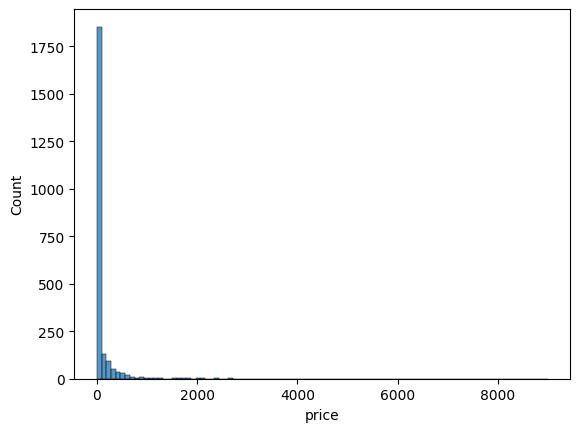

In [25]:
temp_plot = df_benchmarks_final.copy()
temp_plot["price"] = temp_plot["price"].fillna(-1)
sns.histplot(data=temp_plot, x="price")
plt.show()

In [26]:
df_benchmarks_final.shape

(2287, 10)